In [57]:
### Loading IMAGE and MASK data into python lists ###

import os
target_dir = "/home/studio-lab-user/my-datasets/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled"
image_dir = "/home/studio-lab-user/my-datasets/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Classification"
CATEGORIES = ["Flooded", "Non-Flooded"]

mask_paths = sorted(
    [
        os.path.join(target_dir, category, "mask", mask_name)
        for category in CATEGORIES
        for mask_name in os.listdir(os.path.join(target_dir, category, "mask"))
        if mask_name.endswith(".png")
    ]
)

image_paths = []
for path in mask_paths:
    if(path.find("Non-Flooded") != -1): # Check if "Non-FLooded" is present in path
        temp = target_dir + "/" + CATEGORIES[1] + "/mask/"
        im_path = path[len(temp):-8]+".jpg"
        full_path = os.path.join(image_dir, CATEGORIES[1], im_path)
    else: # Otherwise 
        temp = target_dir + "/" + CATEGORIES[0] + "/mask/"
        im_path = path[len(temp):-8] + ".jpg"
        full_path = os.path.join(image_dir, CATEGORIES[0], im_path)             
    image_paths.append(full_path)

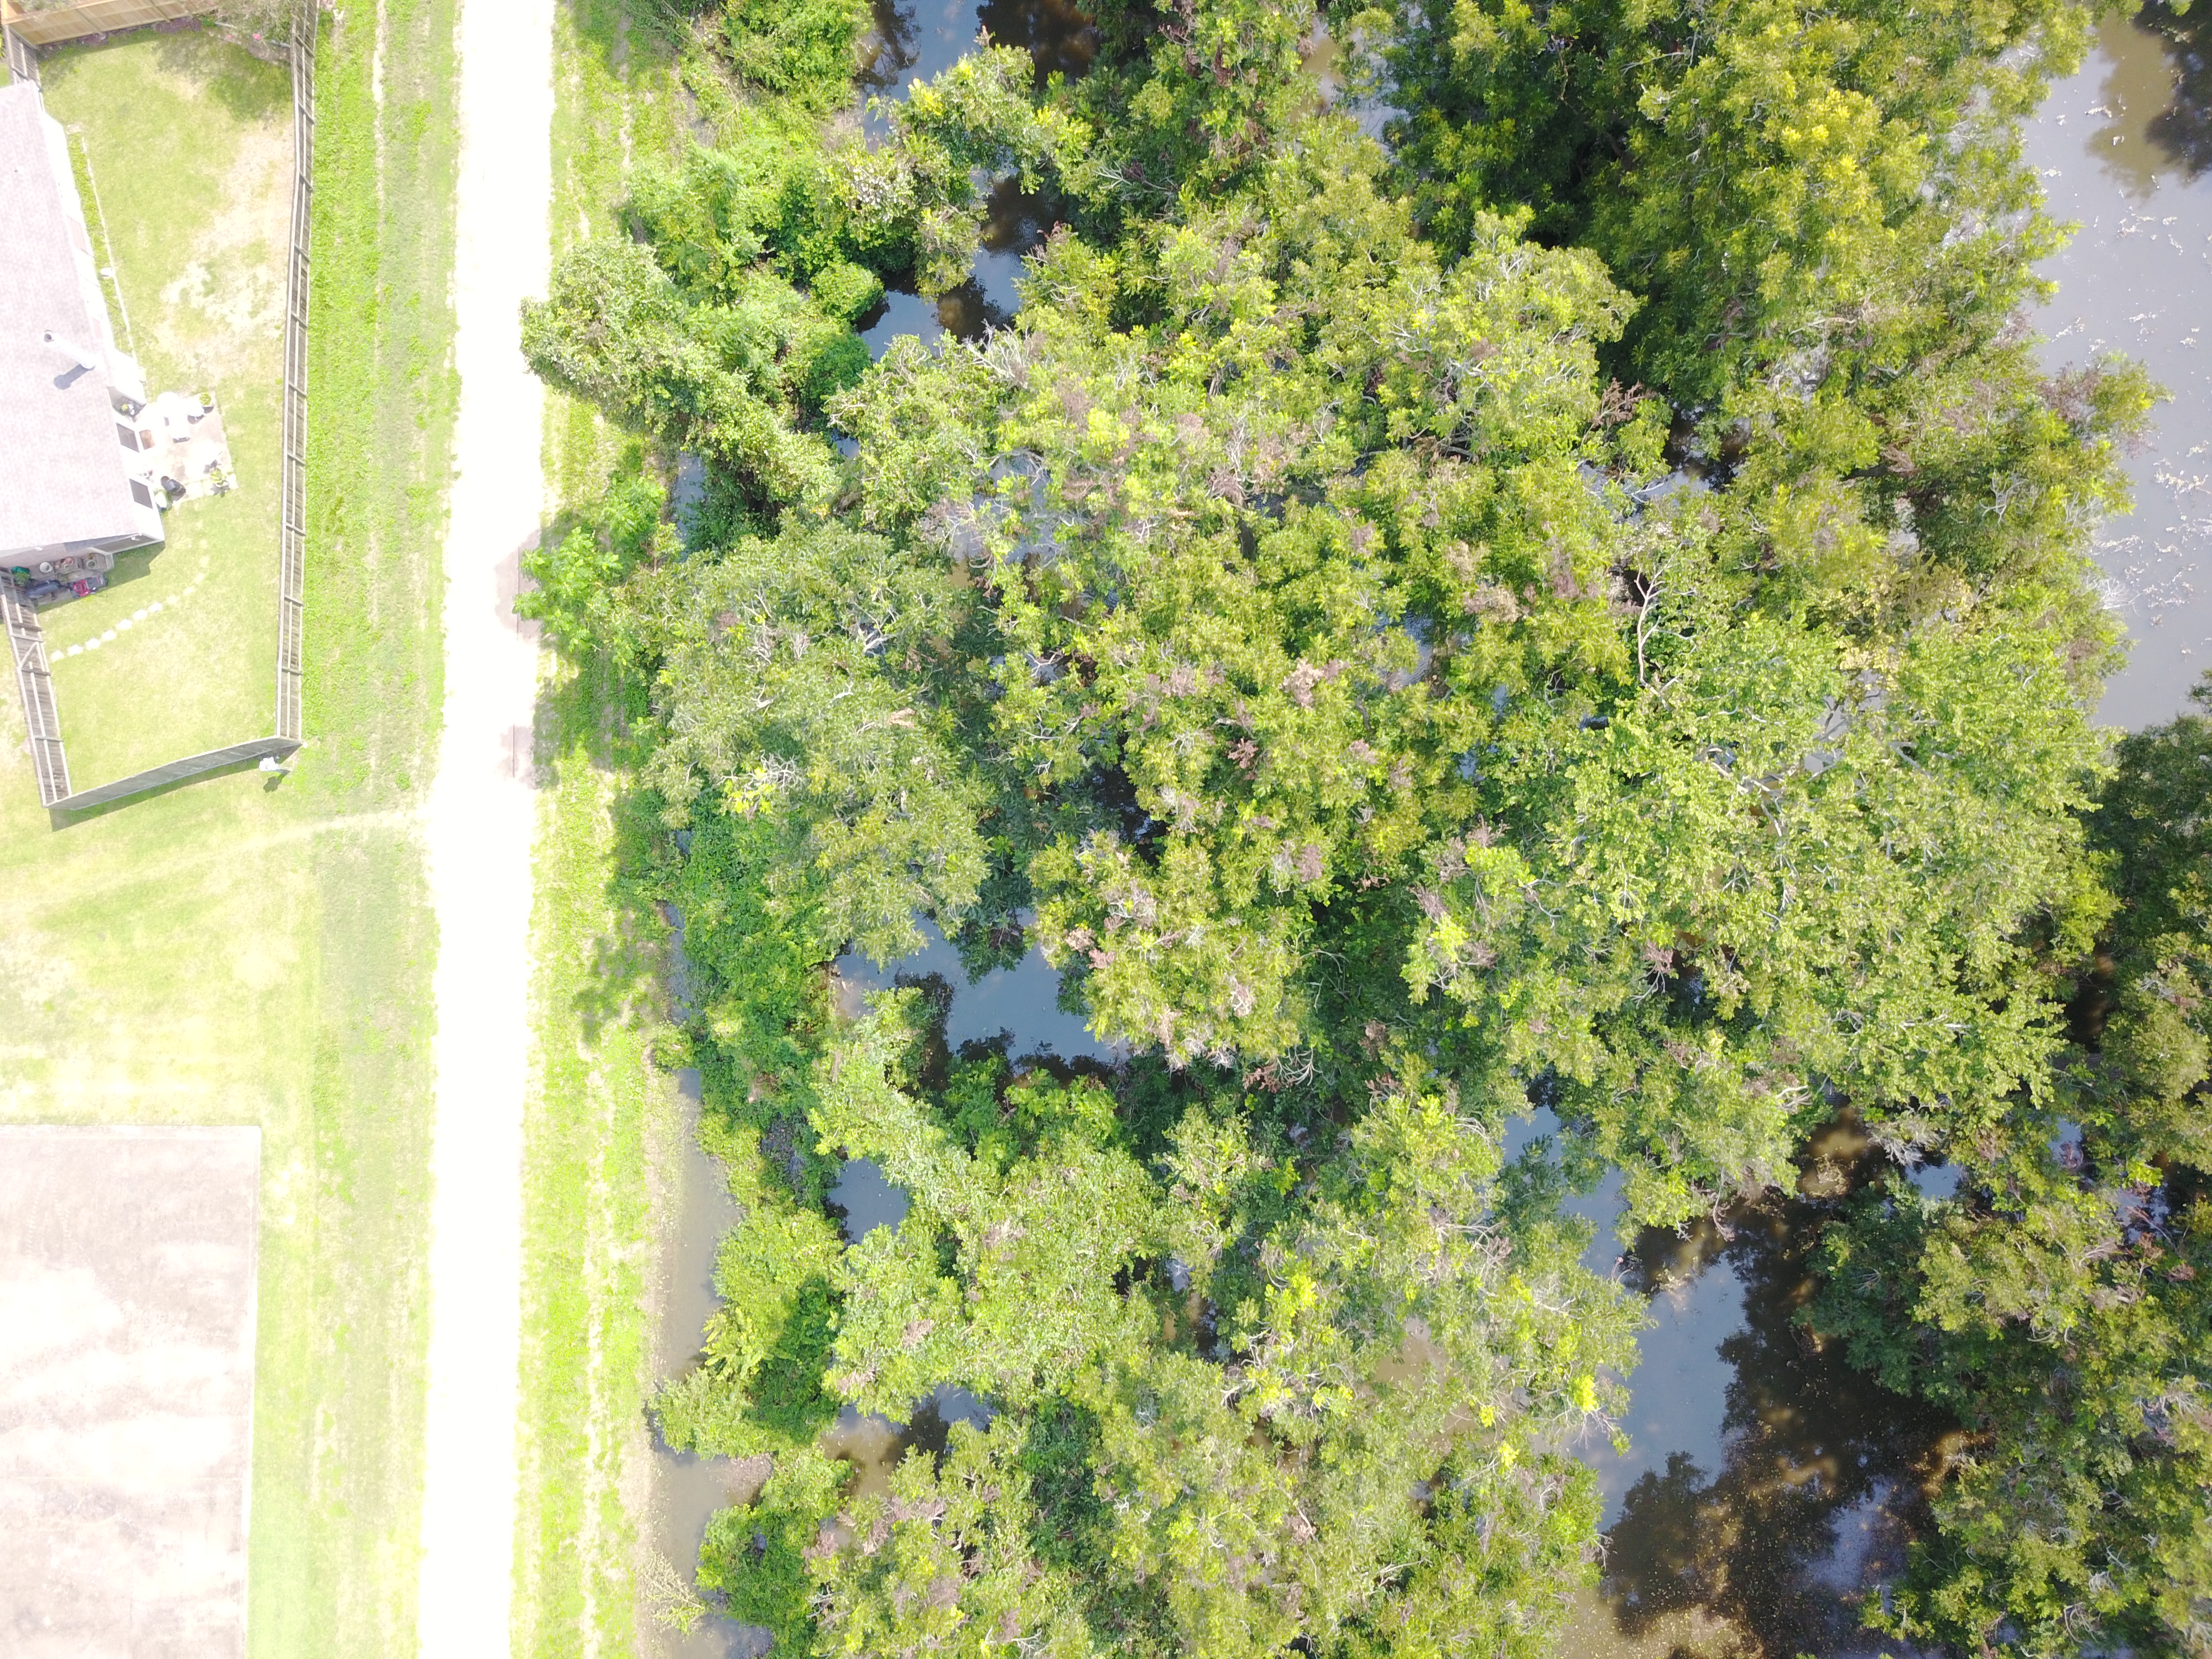

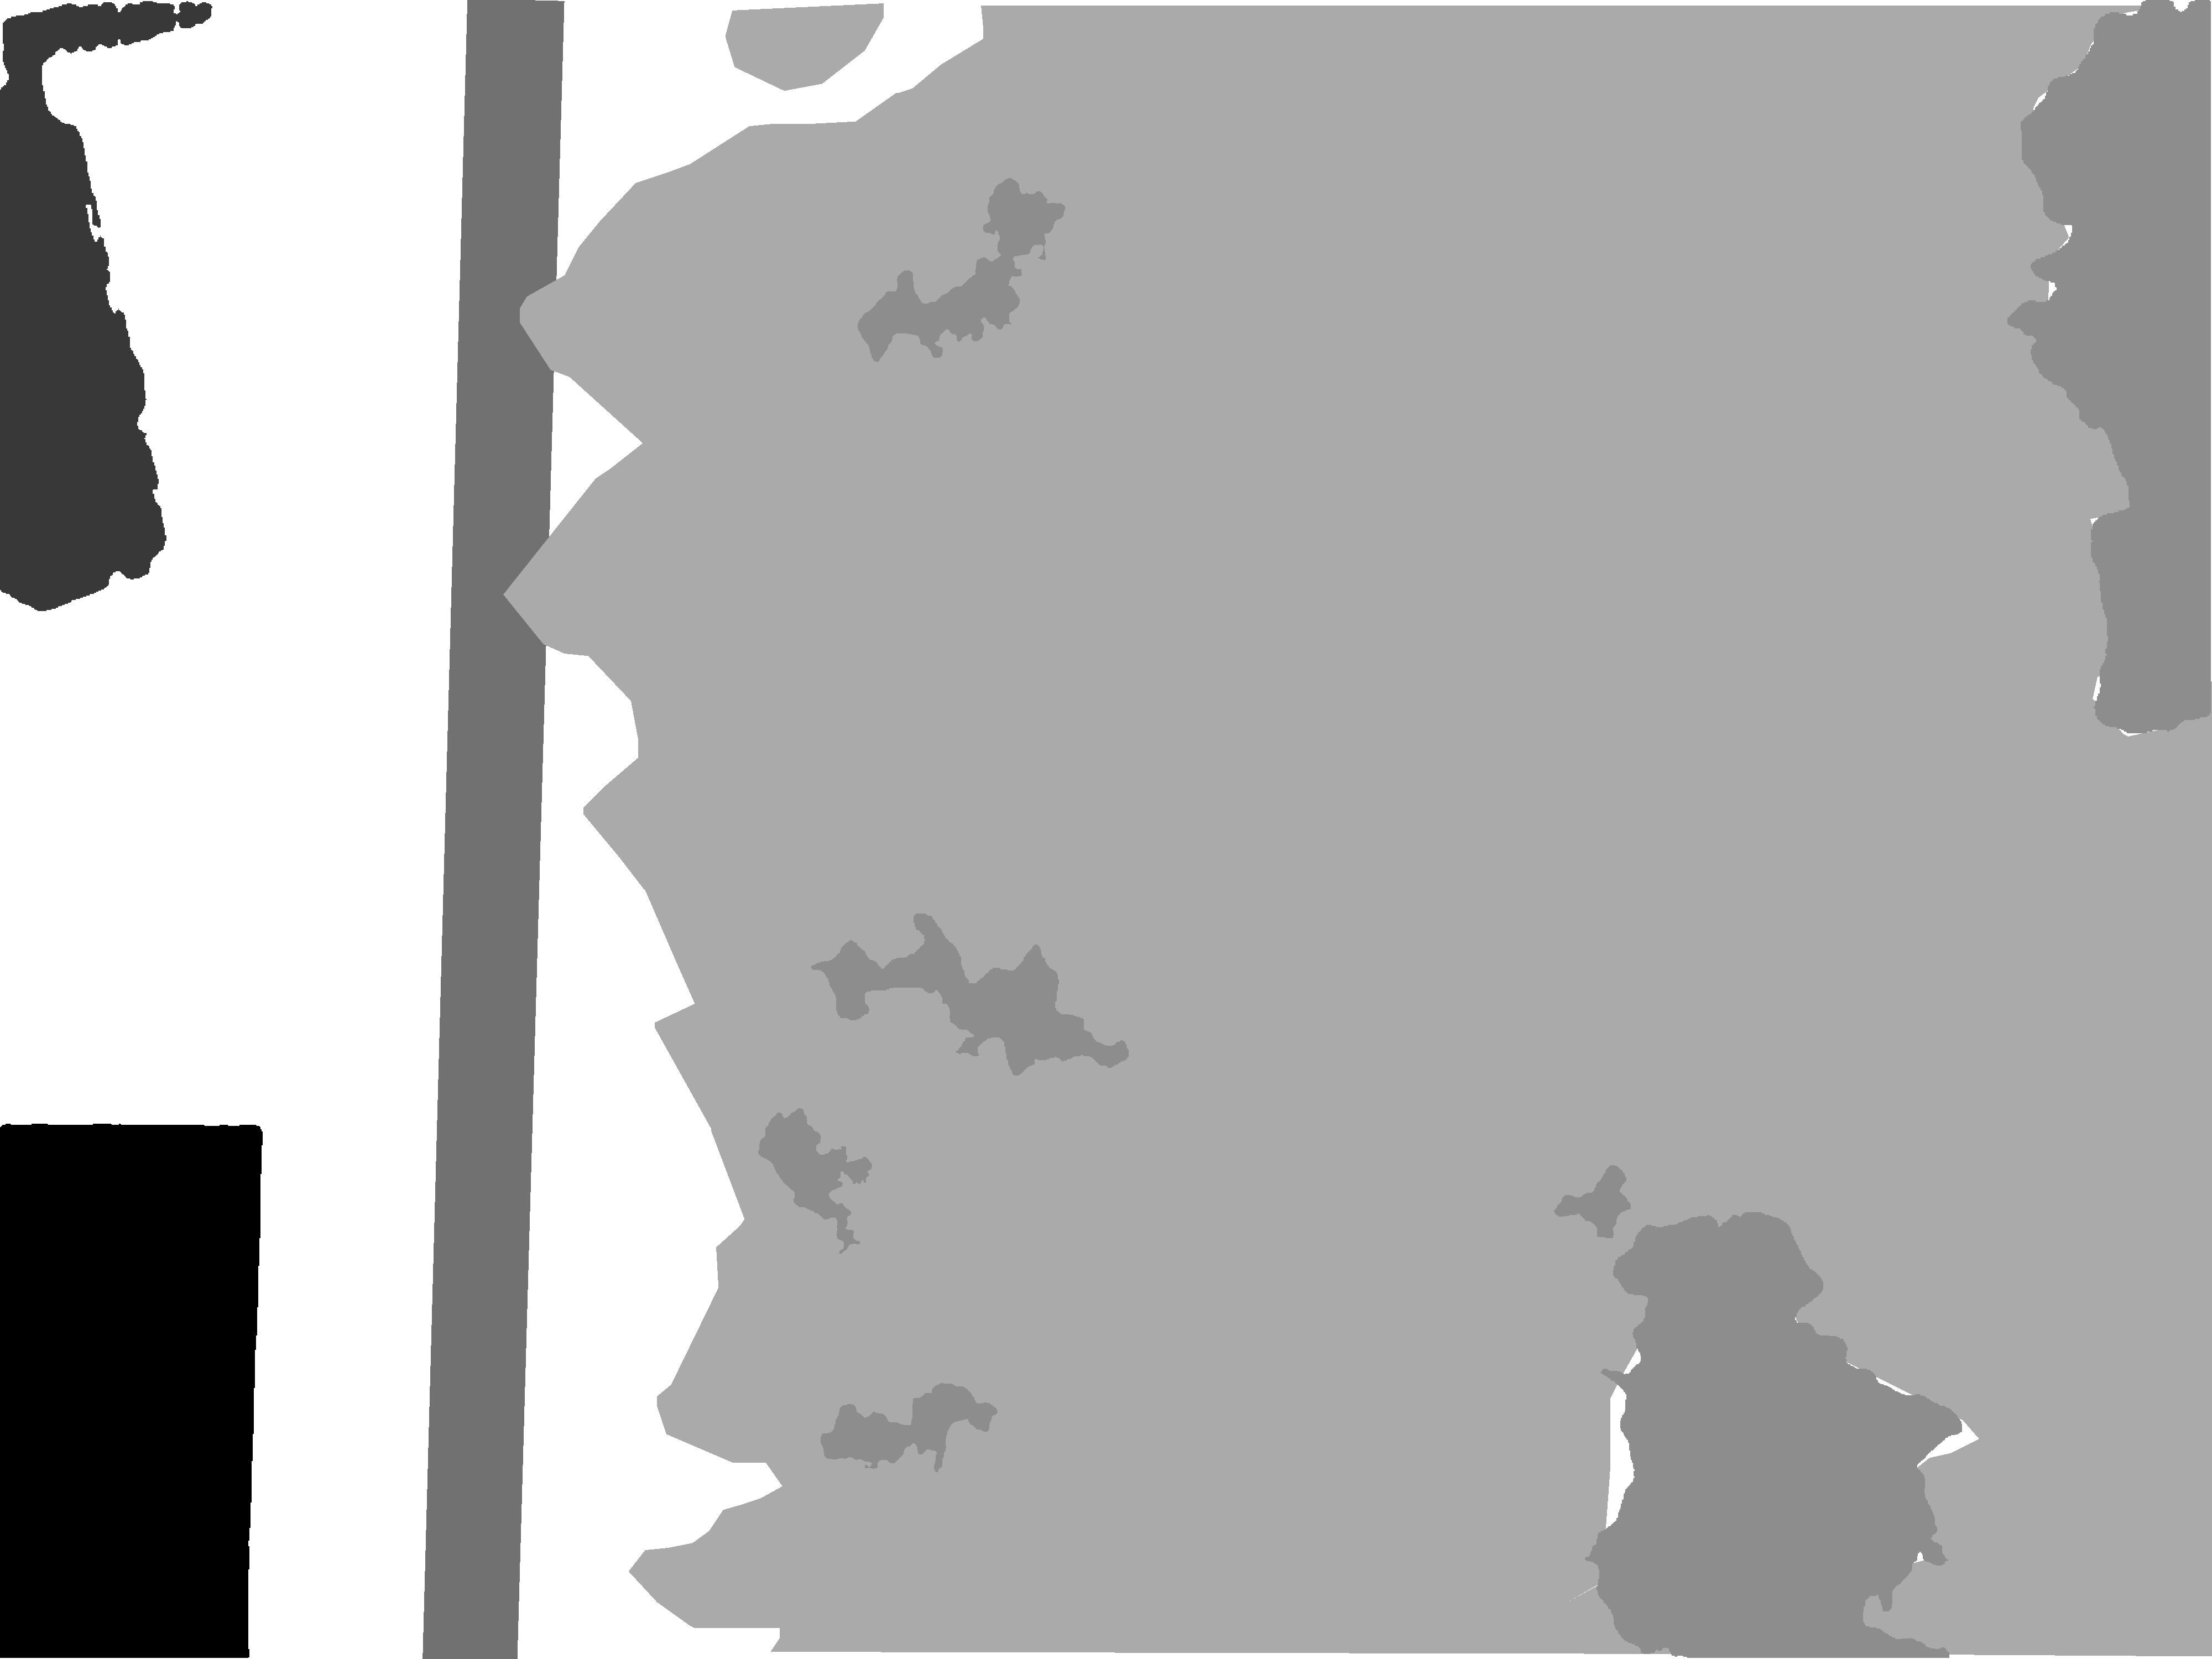

In [70]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

sample_num = 12

# Display input image #7
display(Image(filename=image_paths[sample_num]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(mask_paths[sample_num]))
display(img)

In [83]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

'''
Helper class to load data in batches. Uses keras.utils.Sequence. 
Refer https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
'''

class FloodNetDataLoader(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, image_paths, mask_paths, img_channels=3):
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_channels = img_channels
        self.image_paths = imag_paths
        self.mask_paths = mask_paths
    
    def __len__(self, ):
        return len(self.image_paths)//self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i:i+self.batch_size]
        batch_mask_paths = self.mask_paths[i:i+self.batch_size]
        
        X = np.zeros((self.batch_size,) + self.img_size + (self.img_channels,), dtype="float32")
        for n, path in enumerate(batch_image_paths):
            img = load_image(path=path, target_size=self.img_size)
            X[n] = img
        
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for n, path in enumerate(batch_mask_paths):
            mask = load_image(path=path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(mask, axis=2) # converts (height, width) -> (height, width, 1) to add one channel as grayscale
            
        return X, y

In [84]:
from unet_xception_model import get_model

IMG_SIZE = (450, 600)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session() 

my_model = get_model(img_size=(160, 160), in_channels=3, classes=3)
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [85]:
### Spliting data into Train set and Validation set ###

import random 

random.Random(454).shuffle(image_paths)
random.Random(454).shuffle(mask_paths)

val_samples = 50 # number of data samples being set aside for validation

train_set_images = image_paths[:-val_samples] 
train_set_masks = mask_paths[:-val_samples]
test_set_images = image_paths[-val_samples:]
test_set_masks = mask_paths[-val_samples:]

### Loading the data ###
 batch_size, img_size, image_paths, mask_paths, img_channels=3):
train_set = FloodNetDataLoader(batch_size=